# Imports

In [ ]:
try:
    import pmdarima
except ImportError:
    !pip install pmdarima

# Funções

## Tratamento de Outliers

In [ ]:
import numpy as np
import pandas as pd

# Função para tratar outliers por imputação da média
def treat_outliers(df):
    # Calcula os quartis
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    # Calcula o intervalo interquartil
    iqr = q3 - q1

    # Define os limites inferior e superior
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Substitui os outliers pela média
    df = np.where(df < lower_bound, lower_bound, df)
    df = np.where(df > upper_bound, upper_bound, df)

    return df

## Função de Erros: MAE, MSE e RMSE

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

## Função de Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, model):
    std_dev = np.std(y_pred)
    # Calcula o tamanho dos dados
    valid_size = len(y_true)

    # Plot da previsão
    plt.plot(y_pred[:valid_size], label=model, color='blue')

    # Plot dos valores reais
    plt.plot(y_true.values[:valid_size], label='Real', color='red', linewidth=0.5)

    # Preencher a área entre a média menos o desvio padrão e a média mais o desvio padrão
    plt.fill_between(range(valid_size), y_pred[:valid_size] - std_dev, y_pred[:valid_size] + std_dev, color='lightblue', alpha=0.5)

    plt.title(f'Predicting {name_stock}')
    plt.xlabel(f'{valid_size} days')
    plt.ylabel(f'{name_stock}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Funções Best Predict (Grid Search)

### ARIMA

In [ ]:
import itertools
import pmdarima as pm
import warnings

def find_bestARIMA(x_train, y_train, x_test):
    # Desligar warnings
    warnings.filterwarnings("ignore")

    # Definir os parâmetros para busca em grade
    p_values = range(0, 3)
    d_values = range(0, 3)
    q_values = range(0, 3)

    # Combinar os parâmetros em uma lista de tuplas
    orders = list(itertools.product(p_values, d_values, q_values))

    # Inicializar as variáveis para armazenar os melhores resultados
    best_aic = float("inf")
    best_order = None

    # Iterar sobre as combinações de parâmetros
    for order in orders:
        try:
            # Ajustar o modelo ARIMA com os parâmetros atuais
            arima_model = pm.ARIMA(order=order)
            arima_model.fit(y_train)

            # Calcular o AIC do modelo ajustado
            aic = arima_model.aic()

            # Atualizar os melhores resultados se o AIC atual for menor
            if aic < best_aic:
                best_aic = aic
                best_order = order
        except:
            continue

    # Ajustar o modelo ARIMA final com os melhores parâmetros encontrados
    best_arima_model = pm.ARIMA(order=best_order)
    best_arima_model.fit(y_train)

    # Fazer previsões usando o modelo ARIMA final
    forecasts = best_arima_model.predict(n_periods=len(x_test))

    # (Inutilizado) Fator de amplificação
    #fato_amplificacao = 1

    #residuos_amplificados = residuos[:len(forecasts)] * fato_amplificacao
    #forecasts = forecasts+residuos_amplificados

    # Melhor configuração
    print(best_arima_model.order)

    return (forecasts)

### MLP

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

def find_bestMLP(train, trainTarget, test):
  mlp_parameters = {
      'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,100), (100)],
      'activation': ['logistic', 'relu'],
      'solver': ['adam'],
      'learning_rate': ['constant','adaptive'],
      'alpha': [0.0001, 0.001],
  }

  clfmlp = GridSearchCV(MLPRegressor(random_state=1, max_iter=1000, shuffle=False), mlp_parameters, cv=5, scoring='neg_mean_squared_error')
  clfmlp = clfmlp.fit(train,trainTarget)
  print('MLP best parameters found:\n', clfmlp.best_params_)
  return clfmlp.predict(test)

### SVR

In [ ]:
from sklearn.svm import SVR

def find_bestSVR(train, trainTarget, test):
  svr_parameters = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [10**(-1), 10**0, 10**(1)],
    'epsilon': [10**(-1), 10**(-2), 10**(-3)],
    'gamma': [10**0, 10**(-1), 10**(-2)]
  }

  clfsvr = GridSearchCV(SVR(),svr_parameters, cv=5, scoring='neg_mean_squared_error')
  clfsvr = clfsvr.fit(train,trainTarget)
  print('SVR best parameters found:\n', clfsvr.best_params_)
  return clfsvr.predict(test)

### XGBoost

In [ ]:
import xgboost as xgb
def find_bestXGBoost(train, trainTarget, test):
  xg_params = {
    "colsample_bytree": [0.7, 0.5, 0.3],
    "gamma": [0.1, 0.3, 0.5],
    "learning_rate": [0.03, 0.1, 0.3],
    "max_depth": [2, 3, 6],
    "n_estimators": [100, 125, 150],
    "subsample": [0.6, 0.5, 0.4]
  }

  xg_params = {
    "colsample_bytree": [0.7, 0.5],
  }

  clfxg = GridSearchCV(xgb.XGBRegressor(objective="reg:squarederror", random_state=42), xg_params, cv=5, scoring='neg_mean_squared_error')
  #clfxg = xgb.XGBRegressor(objective="reg:linear", random_state=42)
  clfxg = clfxg.fit(train,trainTarget)
  print('XGBoost best parameters found:\n', clfxg.best_params_)
  return clfxg.predict(test)

### DT

In [ ]:
from sklearn.tree import DecisionTreeRegressor

def find_bestDT(train, trainTarget, test):
  tree_parameters = {
    'splitter': ["best","random"],
    'max_depth': [3,9,12],
    'min_samples_leaf': [2,4,8,10],
    'min_weight_fraction_leaf': [0,0.2,0.5],
    'max_leaf_nodes': [None,10,20,40,90]}

  clftree = GridSearchCV(DecisionTreeRegressor(), tree_parameters, cv=5, scoring='neg_mean_squared_error')
  clftree = clftree.fit(train,trainTarget)
  print('DT best parameters found:\n', clftree.best_params_)
  return clftree.predict(test)

### Mean

In [ ]:
def apply_avg(predict1, predict2):
    return (predict1 + predict2) / 2

### Stacking

In [ ]:
# Importar Stacking
from sklearn.ensemble import StackingRegressor
# Importar os modelos
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

def stacking_model(X_train, y_train, X_test, estimators):
    # Definindo o meta-regressor
    meta_regressor = MLPRegressor(random_state=1, max_iter=1000)  # Pode ser substituído por qualquer outro modelo

    # Criando o modelo de stacking
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_regressor)

    # Treinando o modelo
    stacking_model.fit(X_train, y_train)

    # Fazendo previsões
    predictions = stacking_model.predict(X_test)

    return predictions


### Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA

def bagging_model(X_train, y_train, X_test, base_estimator, n_estimators):
    # Criando o modelo de bagging
    bagging_model = BaggingRegressor(base_estimator=base_estimator, n_estimators=n_estimators, random_state=1)

    # Treinando o modelo
    bagging_model.fit(X_train, y_train)

    # Fazendo previsões
    predictions = bagging_model.predict(X_test)

    return predictions

# Dicionário de Erros

In [ ]:
import pandas as pd

def create_errors_dataframe(model_name, mae, mse, rmse):
    # Criar um dicionário com os erros calculados
    errors_dict = {
        'Model': [model_name],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
    }

    # Converter o dicionário em um DataFrame
    df_errors = pd.DataFrame(errors_dict)

    return df_errors

# Dataloader

In [ ]:
# Conjunto treino e teste
train_factor = 0.7
# Data inicial e final
data_inicial = '2012-05-20'
data_final = '2024-01-31'

In [ ]:
import yfinance as yf

# Obtendo os dados do histórico de preços do Amazon e Nasdaq
data = yf.download(tickers=['ORCL', 'AVGO', 'JPM', 'KO', 'META', 'MSFT'], start=data_inicial, end=data_final, progress=False)['Close']

# Pré Processamento


*   Transformação Logarítmica
*   1-Diferenciação
*   Remoção de valores ausentes
*   Tratamento de Outliers



In [ ]:
# Padronizar a série com transformação log
data_log = np.log(data.dropna()).diff(1).dropna()

In [ ]:
data_log = data_log.apply(treat_outliers)

# Seleção da Ação para Previsão

In [ ]:
stock = 'JPM'                       #'ORCL', 'AVGO', 'JPM', 'KO', 'META', 'MSFT'
name_stock = 'JPMorgan Chase'       #'Oracle', 'Broadcom', 'JPMorgan Chase', 'Coca-Cola', 'Facebook', 'Microsoft'
error_file_name = "jpm_erros.xlsx"
data_file_name = "jpm_data.xlsx"

In [ ]:
data_log = pd.DataFrame(data_log[stock])

In [ ]:
# Calculando o tamanho dos conjuntos de treinamento e teste
train_size = int(len(data_log) * train_factor)
test_size = len(data_log) - train_size

# Dividindo os dados em conjuntos de treinamento e teste
X_train = data_log[:train_size]
X_test = data_log[train_size:]

# Criando as variáveis de destino (y_train e y_test)
# Aqui, y_train será o próximo valor em relação a x_train, e y_test será o próximo valor em relação a x_test
y_train = data_log[:train_size].dropna()
y_test = data_log.shift(-1)[train_size:].dropna()

# ARIMA

In [ ]:
# Predict com ARIMA
predictions_arima = find_bestARIMA(X_train.values.reshape(-1, 1), y_train.values.ravel(), X_test.values.reshape(-1, 1))

(1, 0, 0)


In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_arima, mse_arima, rmse_arima = calculate_metrics(y_test, predictions_arima[1:])
df_errors_arima = create_errors_dataframe('ARIMA', mae_arima, mse_arima, rmse_arima)

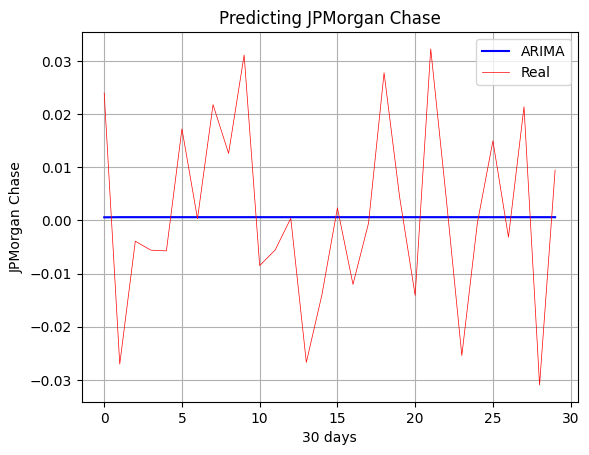

In [ ]:
# Plot Arima X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_arima[1:31], model='ARIMA')

# MLP

In [ ]:
# Predict com MLP
predictions_mlp = find_bestMLP(X_train.values.reshape(-1, 1), y_train.values.ravel(), X_test.values.reshape(-1, 1))

MLP best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF

mae_mlp, mse_mlp, rmse_mlp = calculate_metrics(y_test, predictions_mlp[1:])
df_errors_mlp = create_errors_dataframe('MLP', mae_mlp, mse_mlp, rmse_mlp)

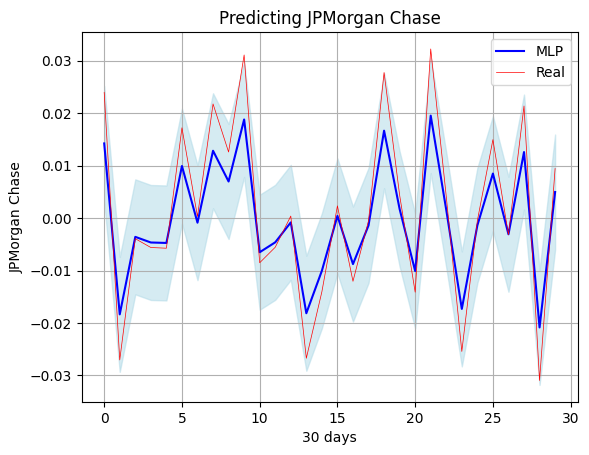

In [ ]:
# Plot MLP X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_mlp[1:31], model='MLP')

# SVR

In [ ]:
# Predict com SVR
predictions_svr = find_bestSVR(X_train.values.reshape(-1, 1), y_train.values.ravel(), X_test.values.reshape(-1, 1))

SVR best parameters found:
 {'C': 10, 'epsilon': 0.001, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF

mae_svr, mse_svr, rmse_svr = calculate_metrics(y_test, predictions_svr[1:])
df_errors_svr = create_errors_dataframe('SVR', mae_svr, mse_svr, rmse_svr)

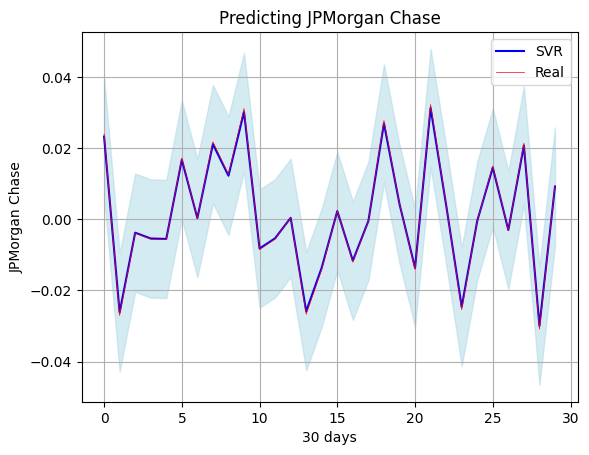

In [ ]:
# Plot SVR X Real

plot_predictions(y_true=y_test[:30], y_pred=predictions_svr[1:31], model='SVR')

# XGBoost

In [ ]:
# Predict com XGBoost
predictions_xgb = find_bestXGBoost(X_train.values.reshape(-1, 1), y_train.values.ravel(), X_test.values.reshape(-1, 1))

XGBoost best parameters found:
 {'colsample_bytree': 0.7}


In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_xgb, mse_xgb, rmse_xgb = calculate_metrics(y_test, predictions_xgb[1:])
df_errors_xgb = create_errors_dataframe('XGB', mae_xgb, mse_xgb, rmse_xgb)

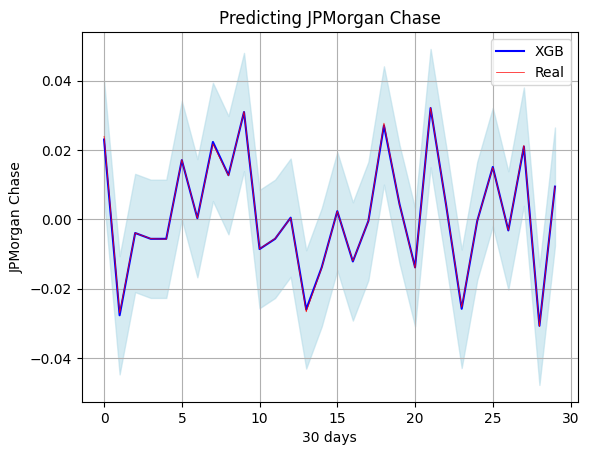

In [ ]:
# Plot XGBoost X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_xgb[1:31], model='XGB')

# Decision Tree Regression

In [ ]:
# Predict com DT
predictions_dt = find_bestDT(X_train.values.reshape(-1, 1), y_train.values.ravel(), X_test.values.reshape(-1, 1))

DT best parameters found:
 {'max_depth': 12, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_dt, mse_dt, rmse_dt = calculate_metrics(y_test, predictions_dt[1:])
df_errors_dt = create_errors_dataframe('DT', mae_dt, mse_dt, rmse_dt)

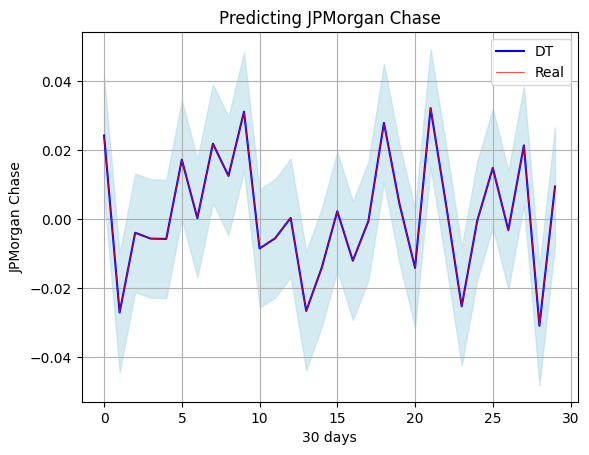

In [ ]:
# Plot DT X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_dt[1:31], model='DT')

# Average

## Mean(MLP, SVR)

In [ ]:
# Ensemble com Média Simples de MLP+SVR
predictions_mlp_svr = apply_avg(predictions_mlp, predictions_svr)

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_mlp_svr, mse_mlp_svr, rmse_mlp_svr = calculate_metrics(y_test, predictions_mlp_svr[1:])
df_errors_mlp_svr = create_errors_dataframe('Mean(MLP, SVR)', mae_mlp_svr, mse_mlp_svr, rmse_mlp_svr)

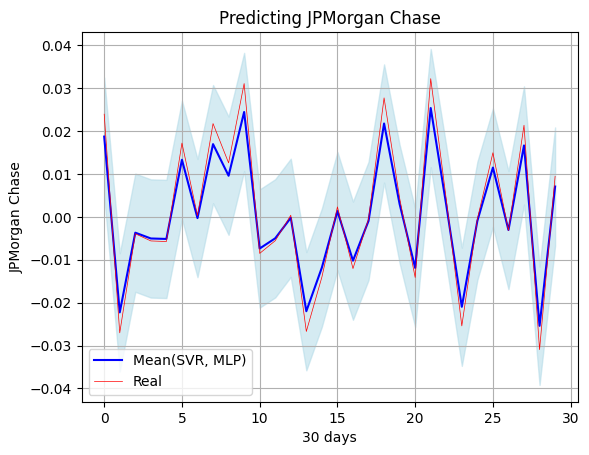

In [ ]:
# Plot Mean(MLP,SVR)
plot_predictions(y_true=y_test[:30], y_pred=predictions_mlp_svr[1:31], model='Mean(SVR, MLP)')

## Mean(ARIMA, SVR)

In [ ]:
# Ensemble com Média Simples de ARIMA+SVR
predictions_arima_svr = apply_avg(predictions_arima, predictions_svr)

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_arima_svr, mse_arima_svr, rmse_arima_svr = calculate_metrics(y_test, predictions_arima_svr[1:])
df_errors_arima_svr = create_errors_dataframe('Mean(ARIMA, SVR)', mae_arima_svr, mse_arima_svr, rmse_arima_svr)

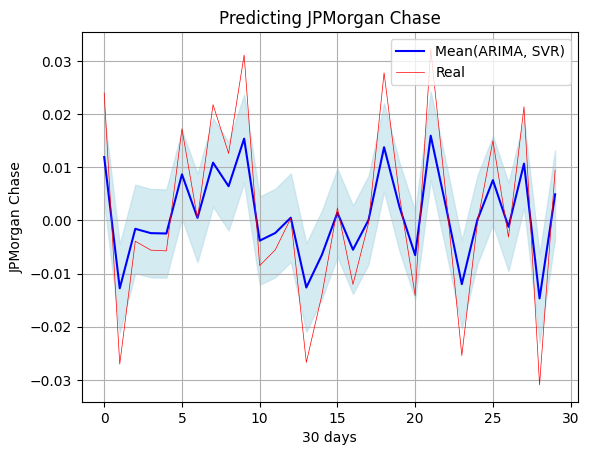

In [ ]:
# Plot Mean(ARIMA,SVR) X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_arima_svr[1:31], model='Mean(ARIMA, SVR)')

## Mean(XGB, MLP)

In [ ]:
# Ensemble com Média Simples de XGB+MLP
predictions_xgb_mlp = apply_avg(predictions_xgb, predictions_mlp)

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_xgb_mlp, mse_xgb_mlp, rmse_xgb_mlp = calculate_metrics(y_test, predictions_xgb_mlp[1:])
df_errors_xgb_mlp = create_errors_dataframe('Mean(XGB, MLP)', mae_xgb_mlp, mse_xgb_mlp, rmse_xgb_mlp)

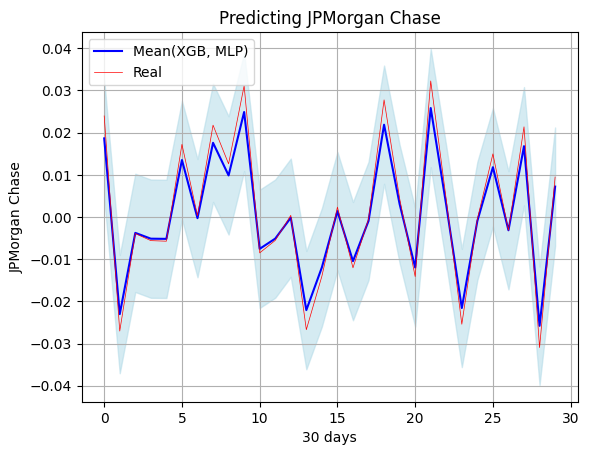

In [ ]:
# Plot Mean(XGB,MLP) X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_xgb_mlp[1:31], model='Mean(XGB, MLP)')

# Stacking

# Stacking(SVR,XGBoost)

In [ ]:
# Definir os modelos base: SVR + XGB
estimators = [
    #('arima', ARIMA()),
    ('svr', SVR()),
    #('mlp', MLPRegressor(random_state=1, max_iter=1000)),
    ('xgb', XGBRegressor(random_state=1)),
    #('dt', DecisionTreeRegressor(random_state=1))
]

In [ ]:
# Stacking de SVR+XGBoost
predictions_stacking_svr_xgb = stacking_model(X_train.values.reshape(-1, 1), y_train.values.ravel(), X_test.values.reshape(-1, 1), estimators)

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_stacking_svr_xgb, mse_stacking_svr_xgb, rmse_stacking_svr_xgb = calculate_metrics(y_test, predictions_stacking_svr_xgb[1:])
df_errors_stacking_svr_xgb = create_errors_dataframe('Stacking(SVR, XGB)', mae_stacking_svr_xgb, mse_stacking_svr_xgb, rmse_stacking_svr_xgb)

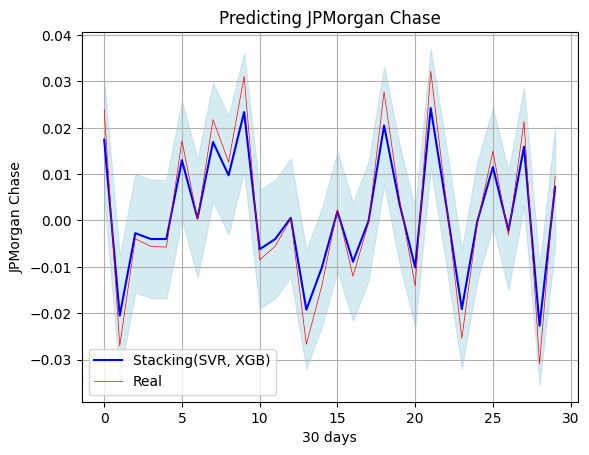

In [ ]:
# Plot Stacking(SVR,XGB) X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_stacking_svr_xgb[1:31], model='Stacking(SVR, XGB)')

# Stacking(MLP,XGBoost)

In [ ]:
# Definir os modelos base MLP + XGB
estimators = [
    #('arima', ARIMA()),
    #('svr', SVR()),
    ('mlp', MLPRegressor(random_state=1, max_iter=1000)),
    ('xgb', XGBRegressor(random_state=1)),
    #('dt', DecisionTreeRegressor(random_state=1))
]

In [ ]:
# Stacking de MLP+XGBoost
predictions_stacking_mlp_xgb = stacking_model(X_train.values.reshape(-1, 1), y_train.values.ravel(), X_test.values.reshape(-1, 1), estimators)

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_stacking_mlp_xgb, mse_stacking_mlp_xgb, rmse_stacking_mlp_xgb = calculate_metrics(y_test, predictions_stacking_mlp_xgb[1:])
df_errors_stacking_mlp_xgb = create_errors_dataframe('Stacking(MLP, XGB)', mae_stacking_mlp_xgb, mse_stacking_mlp_xgb, rmse_stacking_mlp_xgb)

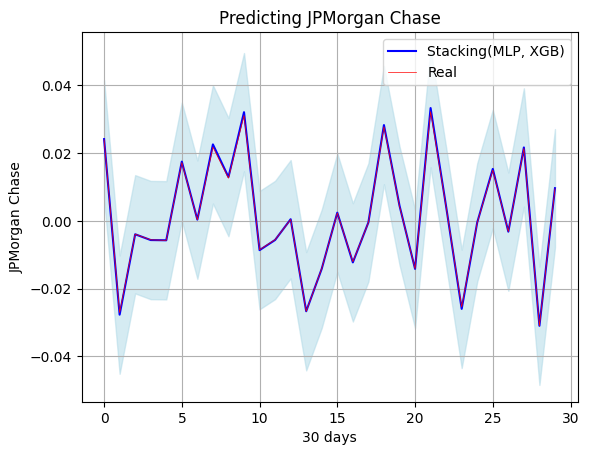

In [ ]:
# Plot Stacking(MLP,XGB) X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_stacking_mlp_xgb[1:31], model='Stacking(MLP, XGB)')

# Bagging

## Bagging(DT)

In [ ]:
# Criando um modelo de Bagging com os estimadores definidos
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=1),
                                  n_estimators=5,      # Número de estimadores para o Bagging
                                  random_state=1)      # Seed para reproducibilidade

# Treinando o modelo
bagging_model.fit(X_train.values.reshape(-1, 1), y_train.values.ravel())




BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=1),
                 n_estimators=5, random_state=1)

In [ ]:
# Bagging DT
predictions_bagging_dt = bagging_model.predict(X_test.values.reshape(-1, 1))

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_bagging_dt, mse_bagging_dt, rmse_bagging_dt = calculate_metrics(y_test, predictions_bagging_dt[1:])
df_errors_bagging_dt = create_errors_dataframe('Bagging(DT)', mae_bagging_dt, mse_bagging_dt, rmse_bagging_dt)

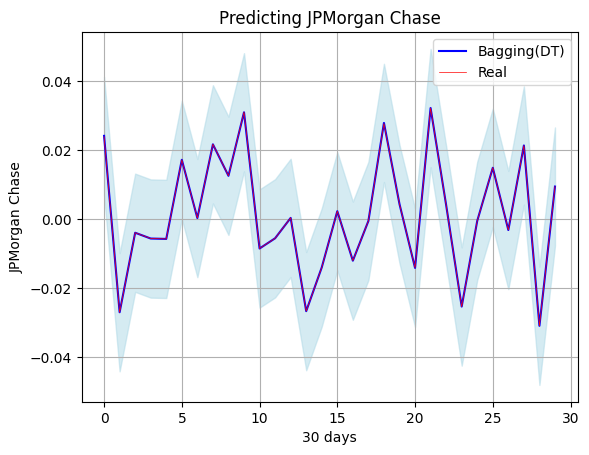

In [ ]:
# Plot Bagging(DT) X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_bagging_dt[1:31], model='Bagging(DT)')

## Bagging(XGB)

In [ ]:
# Criando um modelo de Bagging com os estimadores definidos
bagging_model = BaggingRegressor(base_estimator=XGBRegressor(random_state=1),
                                  n_estimators=5,      # Número de estimadores para o Bagging
                                  random_state=1)      # Seed para reproducibilidade

# Treinando o modelo
bagging_model.fit(X_train.values.reshape(-1, 1), y_train.values.ravel())



BaggingRegressor(base_estimator=XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=None, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=1, ...),
                 n_estimators=5, random_state=1)

In [ ]:
# Bagging de XGB
predictions_bagging_xgb = bagging_model.predict(X_test.values.reshape(-1, 1))

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_bagging_xgb, mse_bagging_xgb, rmse_bagging_xgb = calculate_metrics(y_test, predictions_bagging_xgb[1:])
df_errors_bagging_xgb = create_errors_dataframe('Bagging(XGB)', mae_bagging_xgb, mse_bagging_xgb, rmse_bagging_xgb)

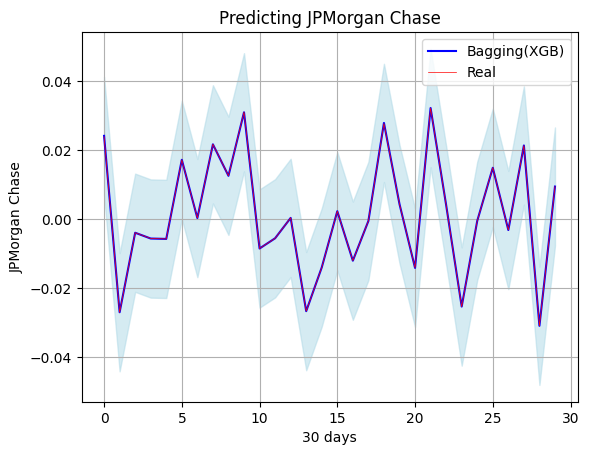

In [ ]:
# Plot Bagging(XGB) X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_bagging_dt[1:31], model='Bagging(XGB)')

## Stacking[Bagging(DT,XGB)]

In [ ]:
from sklearn.linear_model import LinearRegression

# Define os regressores base
dt_regressor = DecisionTreeRegressor()
xgb_regressor = XGBRegressor()

# Cria instâncias do BaggingRegressor para cada regressor
bagging_dt = BaggingRegressor(base_estimator=dt_regressor, n_estimators=5, random_state=1)
bagging_xgb = BaggingRegressor(base_estimator=xgb_regressor, n_estimators=5, random_state=1)

# Treina os modelos Bagging separadamente
bagging_dt.fit(X_train, y_train)
bagging_xgb.fit(X_train, y_train)

# Faz previsões usando os modelos Bagging
predictions_dt = bagging_dt.predict(X_test)
predictions_xgb = bagging_xgb.predict(X_test)

# Cria uma instância do StackingRegressor
stacking_regressor = StackingRegressor(estimators=[
    ('bagging_dt', bagging_dt),
    ('bagging_xgb', bagging_xgb)
], final_estimator=LinearRegression())

# Treina o modelo StackingRegressor
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('bagging_dt',
                               BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                                                n_estimators=5,
                                                random_state=1)),
                              ('bagging_xgb',
                               BaggingRegressor(base_estimator=XGBRegressor(base_score=None,
                                                                            booster=None,
                                                                            callbacks=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsample_bytree=None,
                                                                            device=None,
                                                                            early_stopping_rounds=None,
                                                                            enable_c...
                                                                            learning_rate=None,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=None,
                                                                            max_leaves=None,
                                                                            min_child_weight=None,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=None,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=None, ...),
                                                n_estimators=5,
                                                random_state=1))],
                  final_estimator=LinearRegression())

In [ ]:
# Stacking[Bagging(DT),Bagging(XGB)]
predictions_stacking = stacking_regressor.predict(X_test)

In [ ]:
# Cálculo dos erros MAE, MSE e RMSE e gravação em DF
mae_stacking_bagging, mse_stacking_bagging, rmse_stacking_bagging = calculate_metrics(y_test, predictions_stacking[1:])
df_errors_stacking_bagging = create_errors_dataframe('Stacking[Bagging(DT),Bagging(XGB)]', mae_stacking_bagging, mse_stacking_bagging, rmse_stacking_bagging)

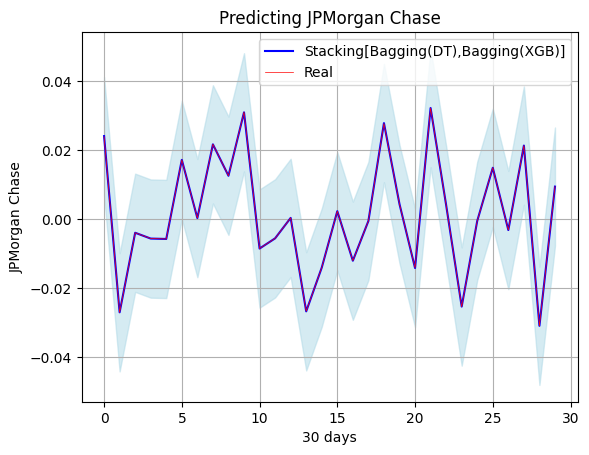

In [ ]:
# Plot Bagging(XGB) X Real
plot_predictions(y_true=y_test[:30], y_pred=predictions_stacking[1:31], model='Stacking[Bagging(DT),Bagging(XGB)]')

# Erros

In [ ]:
dataframesErros = [df_errors_mlp, df_errors_svr, df_errors_arima, df_errors_xgb, df_errors_dt,
                   df_errors_xgb_mlp, df_errors_arima_svr, df_errors_mlp_svr,
                   df_errors_stacking_svr_xgb, df_errors_stacking_mlp_xgb,
                   df_errors_bagging_dt, df_errors_bagging_xgb,
                   df_errors_stacking_bagging]

In [ ]:
dataframesErros = pd.concat(dataframesErros, ignore_index=True)

# Gravando os Dados

In [ ]:
dataframesErros.to_excel(error_file_name)

In [ ]:
# Converte os arrays em DataFrames
df_predicts_arima = pd.DataFrame(predictions_arima, columns=['ARIMA'])
df_predicts_mlp = pd.DataFrame(predictions_mlp, columns=['MLP'])
df_predicts_svr = pd.DataFrame(predictions_svr, columns=['SVR'])
df_predicts_xgb = pd.DataFrame(predictions_xgb, columns=['XGB'])
df_predicts_dt = pd.DataFrame(predictions_dt, columns=['DT'])
df_predicts_mean_mlp_svr = pd.DataFrame(predictions_mlp_svr, columns=['Mean(MLP,SVR)'])
df_predicts_mean_arima_svr = pd.DataFrame(predictions_arima_svr, columns=['Mean(ARIMA,SVR)'])
df_predicts_mean_xgb_mlp = pd.DataFrame(predictions_xgb_mlp, columns=['Mean(XGB,MLP)'])
df_predicts_stacking_svr_xgb = pd.DataFrame(predictions_stacking_svr_xgb, columns=['Stacking(SVR,XGB)'])
df_predicts_stacking_mlp_xgb = pd.DataFrame(predictions_stacking_mlp_xgb, columns=['Stacking(MLP,XGB)'])
df_predicts_bagging_dt = pd.DataFrame(predictions_bagging_dt, columns=['Bagging(DT)'])
df_predicts_bagging_xgb = pd.DataFrame(predictions_bagging_xgb, columns=['Bagging(XGB)'])
df_predicts_stacking_bagging_dt_xgb = pd.DataFrame(predictions_stacking, columns=['Stacking[Bagging(DT,XGB)]'])

In [ ]:
df = pd.concat([y_test.reset_index(), df_predicts_arima, df_predicts_mlp, df_predicts_svr, df_predicts_xgb, df_predicts_dt,
                    df_predicts_mean_mlp_svr, df_predicts_mean_arima_svr, df_predicts_mean_xgb_mlp,
                    df_predicts_stacking_svr_xgb, df_predicts_stacking_mlp_xgb,
                    df_predicts_bagging_dt, df_predicts_bagging_xgb,
                    df_predicts_stacking_bagging_dt_xgb
                    ], axis=1)

In [ ]:
df.to_excel(data_file_name)

In [ ]:
dataframesErros

,Model,MAE,MSE,RMSE
0,MLP,0.004204,2.822358e-05,0.005313
1,SVR,0.000351,1.993694e-07,0.000447
2,ARIMA,0.011294,2.043838e-04,0.014296
3,XGB,0.000132,4.139512e-08,0.000203
4,DT,0.000033,3.847491e-09,0.000062
5,"Mean(XGB, MLP)",0.002112,7.165889e-06,0.002677
6,"Mean(ARIMA, SVR)",0.005823,5.433730e-05,0.007371
7,"Mean(MLP, SVR)",0.002272,8.255469e-06,0.002873
8,"Stacking(SVR, XGB)",0.002864,1.321605e-05,0.003635
9,"Stacking(MLP, XGB)",0.000199,9.041235e-08,0.000301
